# PROJECT 1: DATA ANALYSIS PROJECT

**Table of contents**<a id='toc0_'></a>    
- 1. [Aggregate inflation in Denmark](#toc1_)    
  - 1.1. [Basics](#toc1_1_)    
  - 1.2. [Instantaneous inflation](#toc1_2_)    
  - 1.3. [Core inflation](#toc1_3_)    
  - 1.4. [Disaggregated inflation in Denmark](#toc1_4_)   
- 2. [International Comparison](#toc2_)    
  - 2.1. [CPI vs HICP](#toc2_1_)    
  - 2.2. [Across countries](#toc2_2_)    
- 3. [Extension](#toc2_)  

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [34]:
# Importing packages
import re
import numpy as np
import pandas as pd
from IPython.display import display
import Aflevering as py
import matplotlib.pyplot as plt
from dstapi import DstApi

plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})



## 1. <a id='toc1_'></a>[Aggregate inflation in Denmark](#toc0_)

In [35]:
# Setting up dictionaries for renaming columns and variables for the PRIS113 database
# Making sure that the code is robust with regards to name
columns_dict = {}
columns_dict['TYPE'] = 'variable'
columns_dict['MÅNED'] = 'month'
columns_dict['INDHOLD'] = 'value'

var_dict = {}
var_dict['Forbrugerprisindeks'] = 'CPI'

In [36]:
# Downloading data from PRIS113 database using dstapi
API = DstApi('PRIS113') 
params = API._define_base_params(language='en') # On english, but can also chose to make it on danish by using 'da'
display(params)
API = API.get_data(params)

{'table': 'pris113',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'TYPE', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [37]:
# Renaming columns and variables from the PRIS113 database to the dictionaries defined above
API = API.rename(columns=columns_dict)
for key, value in var_dict.items():
    API.variable.replace(key, value, inplace=True)

API['value'] = pd.to_numeric(API['value'])

API.head()

/var/folders/5l/9j4qn7dd2cjgf8vpr0cs_q_00000gn/T/ipykernel_53043/2493319037.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  API.variable.replace(key, value, inplace=True)


,variable,TID,value
0,Consumer price index,1980M01,33.0
1,Consumer price index,1980M05,34.5
2,Consumer price index,1980M09,35.5
3,Consumer price index,1981M01,36.5
4,Consumer price index,1981M05,38.6


In [38]:
# Renaming TID to Time and converting to datetime
API['date'] = pd.to_datetime(API['TID'], format='%YM%m')
API['year'] = API.date.dt.year
API['month'] = API.date.dt.month

# Dropping TID colonen
API = API.drop(columns=['TID'])

# Se datasættet
API.head()

,variable,value,date,year,month
0,Consumer price index,33.0,1980-01-01,1980,1
1,Consumer price index,34.5,1980-05-01,1980,5
2,Consumer price index,35.5,1980-09-01,1980,9
3,Consumer price index,36.5,1981-01-01,1981,1
4,Consumer price index,38.6,1981-05-01,1981,5


In [39]:
# Sort after date
API = API.sort_values('date').reset_index(drop=True)
# Verifify that it's sorted
API[['date', 'year', 'month', 'value']].head(10)

,date,year,month,value
0,1980-01-01,1980,1,33.0
1,1980-02-01,1980,2,33.3
2,1980-03-01,1980,3,33.8
3,1980-04-01,1980,4,34.0
4,1980-05-01,1980,5,34.5
5,1980-06-01,1980,6,34.6
6,1980-07-01,1980,7,35.2
7,1980-08-01,1980,8,35.3
8,1980-09-01,1980,9,35.5
9,1980-10-01,1980,10,35.8


### 1.1. <a id='toc1_1_'></a>[Basics](#toc0_)

In [ ]:
# Calculated the consumer price index (CPI), P_t, indexed to 100 on average in 2020
cpi_2020_avg = API[API['year'] == 2020]['value'].mean()
print(f"Gennemsnitlig CPI i 2020: {cpi_2020_avg:.2f}")

# Calculate P_t for all years
API['P_t'] = (API['value'] / cpi_2020_avg) * 100

# Look at the results
API[['date', 'year', 'value', 'P_t']].head(10)
API[['date', 'year', 'value', 'P_t']].tail(10)

Gennemsnitlig CPI i 2020: 103.43


,date,year,value,P_t
539,2024-12-01,2024,118.9,114.953271
540,2025-01-01,2025,119.6,115.630035
541,2025-02-01,2025,120.8,116.790203
542,2025-03-01,2025,120.2,116.210119
543,2025-04-01,2025,120.3,116.306800
544,2025-05-01,2025,120.4,116.403481
545,2025-06-01,2025,120.7,116.693522
546,2025-07-01,2025,122.5,118.433774
547,2025-08-01,2025,121.7,117.660329
548,2025-09-01,2025,121.6,117.563648


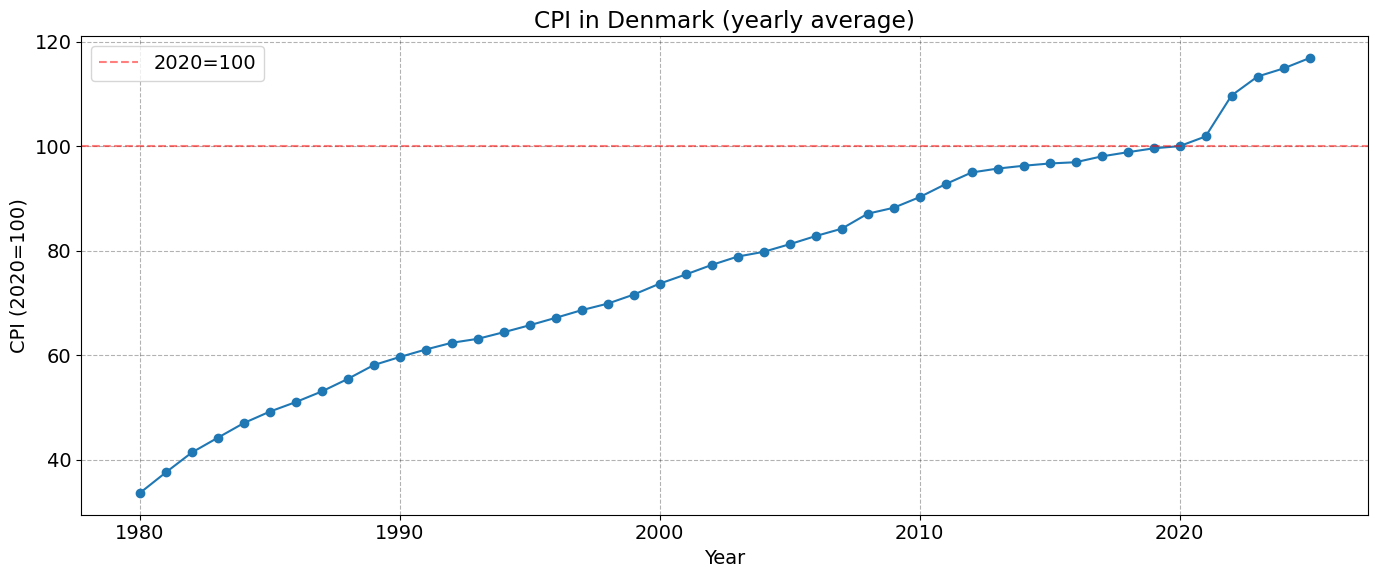

In [41]:
# Calculate yearly average CPI
API_yearly = API.groupby('year')['P_t'].mean().reset_index()

# Plotting the CPI over time
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(API_yearly['year'], API_yearly['P_t'], marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('CPI (2020=100)')
ax.set_title('CPI in Denmark (yearly average)')
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='2020=100')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [49]:
# Calculate month-to-month inflation rate π_t = value_t / value_{t-1} - 1
API['pi_t'] = API['value'] / API['value'].shift(1) - 1

# Look at the results
API[['date', 'year', 'value', 'pi_t']].tail(20)

,date,year,value,pi_t
529,2024-02-01,2024,118.4,0.005093
530,2024-03-01,2024,118.4,0.000000
531,2024-04-01,2024,118.5,0.000845
532,2024-05-01,2024,118.5,0.000000
533,2024-06-01,2024,118.5,0.000000
534,2024-07-01,2024,119.8,0.010970
535,2024-08-01,2024,119.3,-0.004174
536,2024-09-01,2024,118.9,-0.003353
537,2024-10-01,2024,119.6,0.005887
538,2024-11-01,2024,119.2,-0.003344


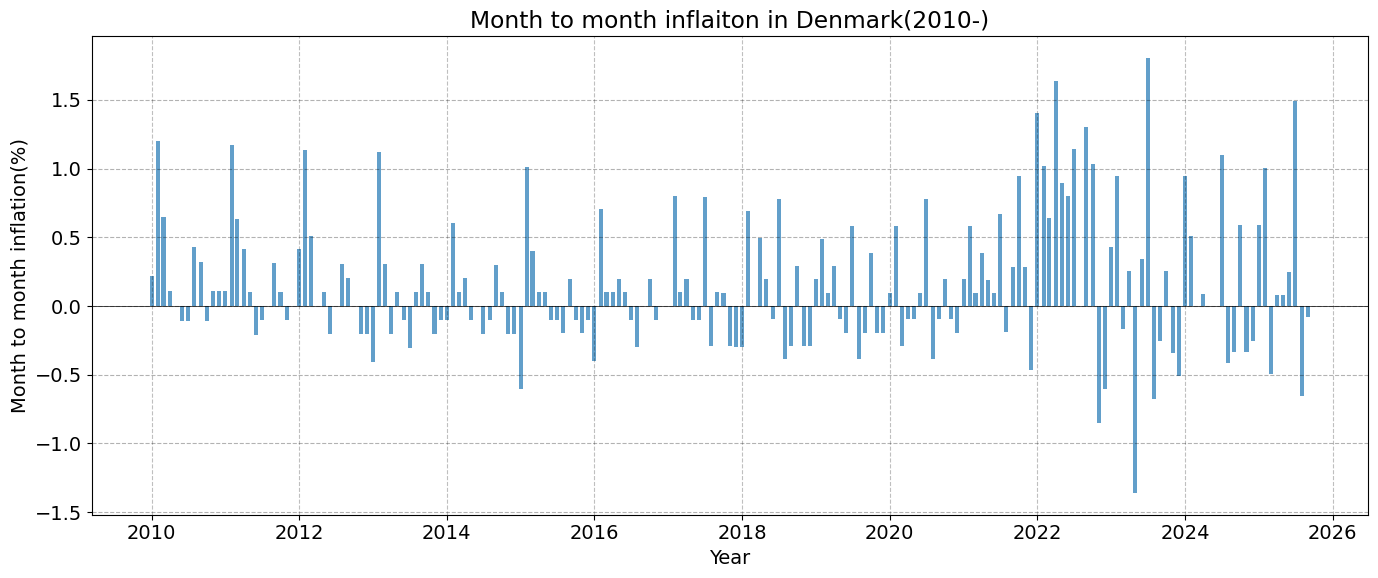

In [50]:
# Filter from 2010
API_2010 = API[API['year'] >= 2010]

# Plot as a barchart
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(API_2010['date'], API_2010['pi_t'] * 100, width=20, alpha=0.7)
ax.set_xlabel('Year')
ax.set_ylabel('Month to month inflation(%)')
ax.set_title('Month to month inflaiton in Denmark(2010-)')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [51]:
# Calculate 12-month inflation rate π_t^12 = value_t / value_{t-12} - 1
API['pi_t_12'] = API['value'] / API['value'].shift(12) - 1

# Se resultatet
API[['date', 'year', 'value', 'pi_t_12']].tail(20)

,date,year,value,pi_t_12
529,2024-02-01,2024,118.4,0.007660
530,2024-03-01,2024,118.4,0.009378
531,2024-04-01,2024,118.5,0.007653
532,2024-05-01,2024,118.5,0.021552
533,2024-06-01,2024,118.5,0.018041
534,2024-07-01,2024,119.8,0.010970
535,2024-08-01,2024,119.3,0.013594
536,2024-09-01,2024,118.9,0.012777
537,2024-10-01,2024,119.6,0.016143
538,2024-11-01,2024,119.2,0.016198


/var/folders/77/y_wqkb2d7nvcjj1l7m69s8cc0000gn/T/ipykernel_19628/358011028.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


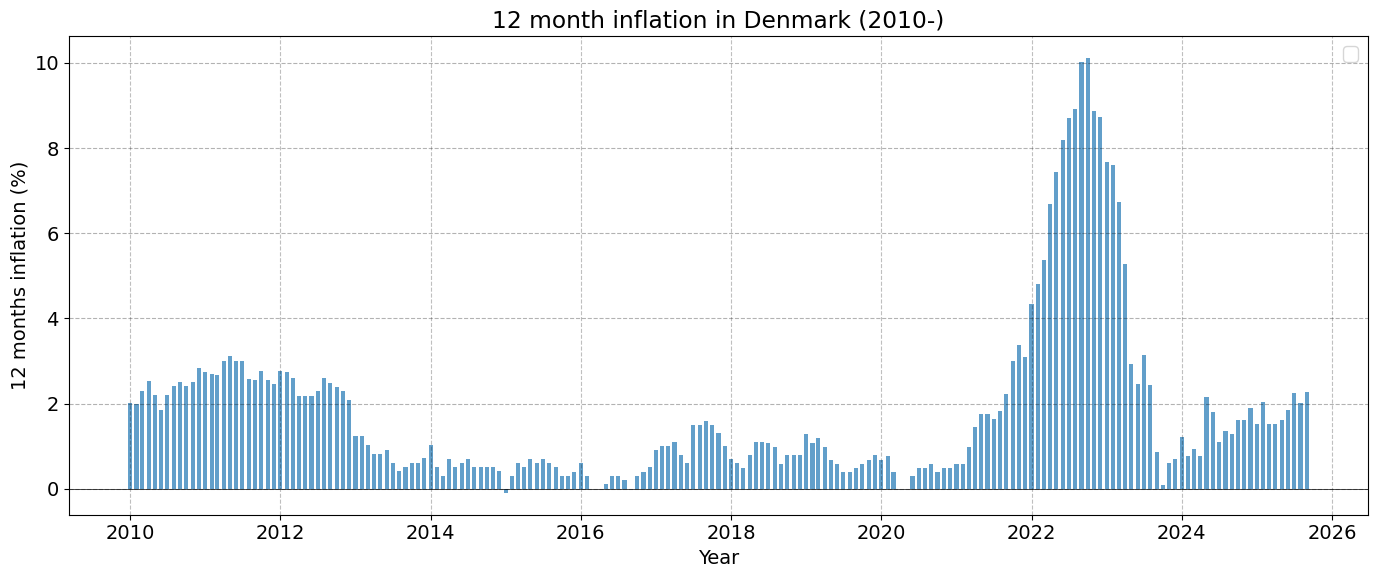

In [52]:
# Filter from 2010
API_2010 = API[API['year'] >= 2010]

# Plot as a barchart
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(API_2010['date'], API_2010['pi_t_12'] * 100, width=20, alpha=0.7)
ax.set_xlabel('Year')
ax.set_ylabel('12 months inflation (%)')
ax.set_title('12 month inflation in Denmark (2010-)')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')
ax.legend()
plt.tight_layout()
plt.show()

**When did the post-pandemic inflation surge end in Denmark?**

The post-pandemic inflation surge in Denmark peaked in late 2022 to early 2023, reaching approximately 10% on a 12-month basis. After this peak, inflation declined steadily throughout 2023. By late 2023 and into early 2024, inflation had returned to around 2% or below, comparable to pre-pandemic levels. The month-to-month data shows that price volatility also normalized during this period. While inflation rates returned to target levels, the cumulative CPI index shows that the overall price level remained permanently elevated from the surge.

### 1.2. <a id='toc1_2_'></a>[Instantaneous inflation](#toc0_)

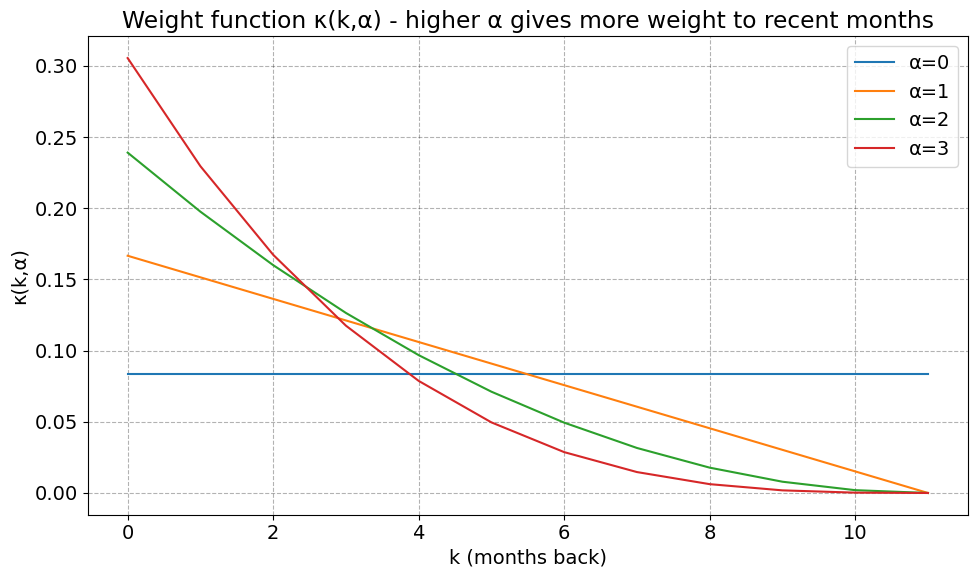

In [53]:
# 1. Setting start values and computing kappa(k,α)
T = 11
k_values = np.arange(0, 12)
alpha_values = [0, 1, 2, 3]

def compute_kappa(k, alpha, T=11):
    """Beregn vægtfunktion κ(k, α)"""
    if alpha == 0:
        return 1/12  # Lige vægtning når α=0
    numerator = (T - k)**alpha
    denominator = sum((T - j)**alpha for j in range(12))
    return numerator / denominator

# Plot κ(k,α) for k = 0,1,...,11 og α = 0,1,2,3
fig, ax = plt.subplots(figsize=(10, 6))
for alpha in alpha_values:
    kappas = [compute_kappa(k, alpha) for k in k_values]
    ax.plot(k_values, kappas, marker='', label=f'α={alpha}')

ax.set_xlabel('k (months back)')
ax.set_ylabel('κ(k,α)')
ax.set_title('Weight function κ(k,α) - higher α gives more weight to recent months')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
# 2. Compute π_t^{12,α} using rolling method
def compute_instantaneous_inflation_rolling(pi_t, alpha):
    """
    Compute π_t^{12,α} using rolling window
    pi_t: monthly inflation rates (as decimals)
    """
    def weighted_inflation(window):
        if len(window) < 12:
            return np.nan
        # Window is ordered oldest to newest, reverse to match k indexing
        # where k=0 is most recent
        window_reversed = window[::-1]
        # Compute weighted geometric mean: ∏(1 + π_t-k)^κ(k,α) - 1
        weights = [compute_kappa(k, alpha) for k in range(12)]
        product = np.prod((1 + window_reversed) ** weights)
        return product - 1
    
    return pi_t.rolling(window=12).apply(weighted_inflation, raw=True)

# Calculate for all α values
for alpha in alpha_values:
    API[f'pi_inst_alpha_{alpha}'] = compute_instantaneous_inflation_rolling(API['pi_t'], alpha)

# Verify that at α=0, it gives the same result as standard 12-month inflation
print("Comparison α=0 vs standard 12-month inflation:")
comparison = API[['date', 'pi_t_12', 'pi_inst_alpha_0']].tail(10)
comparison['difference'] = comparison['pi_t_12'] - comparison['pi_inst_alpha_0']
print(comparison)


Comparison α=0 vs standard 12-month inflation:
          date   pi_t_12  pi_inst_alpha_0  difference
539 2024-12-01  0.018852         0.001558    0.017294
540 2025-01-01  0.015280         0.001265    0.014016
541 2025-02-01  0.020270         0.001674    0.018597
542 2025-03-01  0.015203         0.001258    0.013945
543 2025-04-01  0.015190         0.001257    0.013933
544 2025-05-01  0.016034         0.001326    0.014707
545 2025-06-01  0.018565         0.001534    0.017031
546 2025-07-01  0.022538         0.001859    0.020679
547 2025-08-01  0.020117         0.001661    0.018456
548 2025-09-01  0.022708         0.001873    0.020835


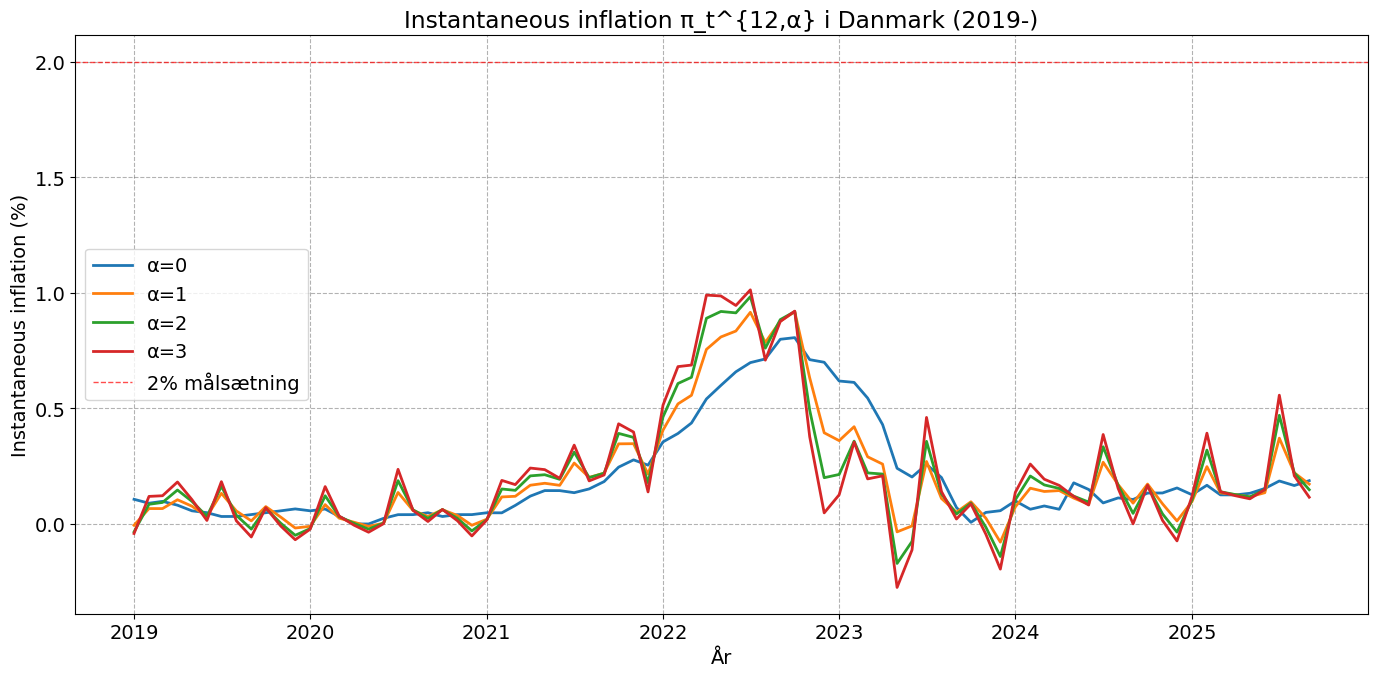


Hvornår toppede inflationen for forskellige α:
α=0: 2022-10, 0.81%
α=1: 2022-10, 0.92%
α=2: 2022-07, 0.98%
α=3: 2022-07, 1.01%


In [55]:
# 3. Plot siden 2019
API_2019 = API[API['year'] >= 2019]

fig, ax = plt.subplots(figsize=(14, 7))
for alpha in alpha_values:
    ax.plot(API_2019['date'], API_2019[f'pi_inst_alpha_{alpha}'] * 100, 
            label=f'α={alpha}', linewidth=2)

ax.set_xlabel('År')
ax.set_ylabel('Instantaneous inflation (%)')
ax.set_title('Instantaneous inflation π_t^{12,α} i Danmark (2019-)')
ax.axhline(y=2, color='red', linestyle='--', linewidth=1, alpha=0.7, label='2% målsætning')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Find hvornår inflationen toppede for forskellige α
print("\nHvornår toppede inflationen for forskellige α:")
for alpha in alpha_values:
    post_2020 = API[API['year'] >= 2020]
    peak_idx = post_2020[f'pi_inst_alpha_{alpha}'].idxmax()
    peak_data = post_2020.loc[peak_idx]
    print(f"α={alpha}: {peak_data['date'].strftime('%Y-%m')}, {peak_data[f'pi_inst_alpha_{alpha}']*100:.2f}%")

The standard measure (α = 0) peaks in late 2022 at 0.8%. The high-α measures
(α = 2, 3) peak earlier in mid-2022 at 1.0% and decline sharply thereafter—reaching
negative territory by late 2023 while α = 0 remains elevated.
This suggests high-α measures can signal turning points months ahead of standard
inflation, acting as an early warning system, while α = 0 provides a more stable
structural view of inflationary periods.

### 1.3. <a id='toc1_2_'></a>[Core inflation](#toc0_)

In [56]:
# Get data from PRIS111 (Consumer Price Index - detailed)
pris111_api = DstApi('PRIS111')

params = pris111_api._define_base_params(language='en')
display(params)
pris111 = pris111_api.get_data(params)

#see unique values in various columns
print(pris111['ENHED'].unique()) 
print(pris111['VAREGR'].unique())

{'table': 'pris111',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'VAREGR', 'values': ['*']},
  {'code': 'ENHED', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

['Index' 'Percentage change compared to previous month (per cent)'
 'Percentage change compared to same month the year before (per cent)']
['04.4.4.2 Security services'
 '04.4.4.9 Other services related to dwelling'
 '04.5 Electricity, gas and other fuels' '04.5.1 Electricity' '04.5.2 Gas'
 '04.5.2.1 Natural gas and town gas'
 '04.5.2.2 Liquefied hydrocarbons (butane, propane, etc.)'
 '04.5.3 Liquid fuels' '04.5.4 Solid fuels' '04.5.4.1 Coal'
 '04.5.4.9 Other solid fuels' '04.5.5 Heat energy'
 '05. Furnishings, household equipment and routine household maintenance '
 '05.1 Furniture and furnishings, carpets and other floor coverings'
 '05.1.1 Furniture and furnishings' '05.1.1.1 Household furniture'
 '05.1.1.2 Garden furniture' '05.1.1.3 Lighting equipment'
 '05.1.1.9 Other furniture and furnishings'
 '05.1.2 Carpets and other floor coverings' '05.1.2.1 Carpets and rugs'
 '05.1.2.2 Other floor coverings'
 '05.1.2.3 Services of laying of fitted carpets and floor coverings'
 '05.1.3 Repa

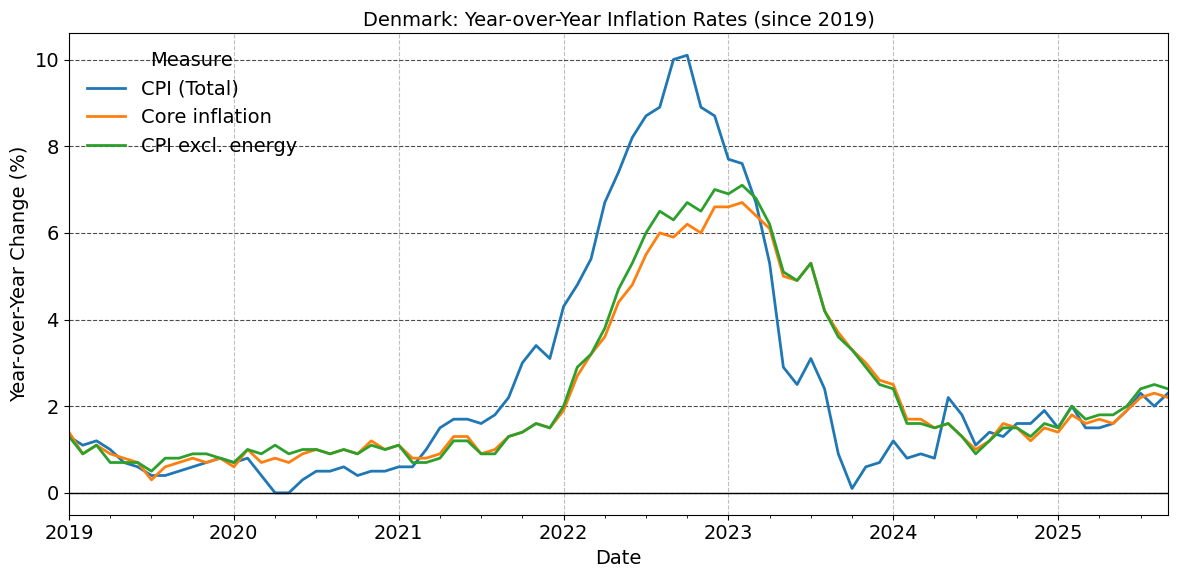

In [57]:
# Define filters (relevant groups and unit)
target_unit = "Percentage change compared to same month the year before (per cent)"
groups = [
    "00 Consumer price index, total",
    "15.1 Overall Consumer Price Index excl. energy",
    "14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)",
]

# using the filters
df = pris111.loc[
    (pris111["ENHED"] == target_unit) & (pris111["VAREGR"].isin(groups)),
    ["TID", "VAREGR", "INDHOLD"]
].copy()

# Convert to numeric & datetime 
df["INDHOLD"] = pd.to_numeric(df["INDHOLD"], errors="coerce")
df["date"] = pd.to_datetime(df["TID"].str.replace("M", "-"), format="%Y-%m", errors="coerce")

# --- Aggregate if duplicates ---
#df = df.groupby(["date", "VAREGR"], as_index=False)["INDHOLD"].mean()

# Pivot to wide format 
wide = (
    df.pivot(index="date", columns="VAREGR", values="INDHOLD")
      .sort_index()
      .loc["2019-01-01":]
)

# Rename for cleaner legend labels ---
name_map = {
    "00 Consumer price index, total": "CPI (Total)",
    "15.1 Overall Consumer Price Index excl. energy": "CPI excl. energy",
    "14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)": "Core inflation",
}
wide = wide.rename(columns=name_map) #applying the rename

# Plot 
fig, ax = plt.subplots(figsize=(12, 6))
wide.plot(ax=ax, linewidth=2)
ax.axhline(0, color="black", linewidth=1)
ax.set_title("Denmark: Year-over-Year Inflation Rates (since 2019)", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Year-over-Year Change (%)")
ax.legend(title="Measure", loc="upper left", frameon=False)
ax.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

**Comments on the figure** :

Using the PRIS111 table from Statistics Denmark, we can decompose inflation into several distinct groups. This allows us to separate the effects of energy and food prices from what is often referred to as core inflation.

The figure above displays the annual growth rate of overall inflation, inflation excluding energy, and inflation excluding both energy and food. The figure shows that particular energy has been a driving factor in the large inflation we experienced towards the end of 2022. 

### 1.4. <a id='toc1_4_'></a>[Disaggregated inflation in Denmark](#toc0_)

In [ ]:
# Inspect the category levels
levels = DstApi('PRIS111').variable_levels('VAREGR', language='en')

# Print all categories
for row in levels.itertuples():
    print(row.id, "-", row.text)

000000 - 00 Consumer price index, total
010000 - 01 Food and non-alcoholic beverages
011000 - 01.1 Food
011100 - 01.1.1 Bread and cereals
011110 - 01.1.1.1 Rice
011120 - 01.1.1.2 Flours and other cereals
011130 - 01.1.1.3 Bread
011140 - 01.1.1.4 Other bakery products
011150 - 01.1.1.5 Pizza and quiche
011160 - 01.1.1.6 Pasta products and couscous
011170 - 01.1.1.7 Breakfast cereals
011180 - 01.1.1.8 Other cereal products
011200 - 01.1.2 Meat
011210 - 01.1.2.1 Beef and veal
011220 - 01.1.2.2 Pork
011230 - 01.1.2.3 Lamb and goat
011240 - 01.1.2.4 Poultry
011260 - 01.1.2.6 Edible offal
011270 - 01.1.2.7 Dried, salted or smoked meat
011280 - 01.1.2.8 Other meat preparations
011300 - 01.1.3 Fish and seafood
011310 - 01.1.3.1 Fresh or chilled fish
011320 - 01.1.3.2 Frozen fish
011340 - 01.1.3.4 Frozen seafood
011350 - 01.1.3.5 Dried, smoked or salted fish and seafood
011360 - 01.1.3.6 Other preserved or processed fish and seafood-based preparations
011400 - 01.1.4 Milk, cheese and eggs
01141

In [59]:
# We extract the numeric part from 'text' (before the first space)
levels['numcode'] = levels['text'].str.extract(r'^([\d\.]+)')

# Remove dots and count digits
levels['numcode_clean'] = levels['numcode'].str.replace('.', '', regex=False)

# Keep only those with 4 digits
filtered = levels[levels['numcode_clean'].str.len() == 4]

# Print the result
for row in filtered.itertuples():
    print(row.id, "-", row.text)

011100 - 01.1.1 Bread and cereals
011200 - 01.1.2 Meat
011300 - 01.1.3 Fish and seafood
011400 - 01.1.4 Milk, cheese and eggs
011500 - 01.1.5 Oils and fats
011600 - 01.1.6 Fruit
011700 - 01.1.7 Vegetables
011800 - 01.1.8 Sugar, jam, honey, chocolate and confectionery
011900 - 01.1.9 Food products n.e.c.
012100 - 01.2.1 Coffee, tea and cocoa
012200 - 01.2.2 Mineral waters, soft drinks, fruit and vegetable juices
021100 - 02.1.1 Spirits
021200 - 02.1.2 Wine
021300 - 02.1.3 Beer
031100 - 03.1.1 Clothing materials
031200 - 03.1.2 Garments
031300 - 03.1.3 Other articles of clothing and clothing accessories
031400 - 03.1.4 Cleaning, repair and hire of clothing
032100 - 03.2.1 Shoes and other footwear
032200 - 03.2.2 Repair and hire of footwear
041100 - 04.1.1 Actual rentals paid by tenants
041200 - 04.1.2 Other actual rentals
042100 - 04.2.1 Imputed rentals of owner-occupiers
042200 - 04.2.2 Other imputed rentals
043100 - 04.3.1 Materials for the maintenance and repair of the dwelling
043200

In [60]:
# --- metadata for canonical names at 01.1.1 level (optional but nice) ---
levels = DstApi('PRIS111').variable_levels('VAREGR', language='en').copy()
names_3seg = (
    levels['text']
      .str.extract(r'^(?P<code3>\d{2}\.\d\.\d)\s+(?P<name3>.+)$')
      .dropna()
      .drop_duplicates()
)

# --- prices ---
prices = pris111[pris111['ENHED'] == 'Index'].copy()

# Keep ONLY rows where VAREGR is EXACTLY three segments: "01.1.1 <name>"
exact_3seg = prices['VAREGR'].str.match(r'^\d{2}\.\d\.\d\s')
prices = prices.loc[exact_3seg].copy()

# Extract code + (raw) name from VAREGR
m = prices['VAREGR'].str.extract(r'^(?P<code3>\d{2}\.\d\.\d)\s+(?P<name_raw>.+)$')
prices = pd.concat([prices, m], axis=1)   # avoids the "columns overlap" join error

# Parse value and date
prices['INDHOLD'] = pd.to_numeric(prices['INDHOLD'].astype(str).str.replace(',', '.'), errors='coerce')
prices['date'] = pd.to_datetime(prices['TID'].str.replace('M', '-'), format='%Y-%m', errors='coerce')

# Drop rows without value/date
prices = prices.dropna(subset=['INDHOLD', 'date'])

# Attach canonical name (if available)
prices = prices.merge(names_3seg, on='code3', how='left')
prices['name'] = prices['name3'].fillna(prices['name_raw'])
prices = prices.drop(columns=['name3'])

# Sanity checks (should be zero)
#   multiple rows per (date, code3)?
dupes = prices.duplicated(['date', 'code3'], keep=False).sum()
#   any NaNs left in INDHOLD?
n_nans = prices['INDHOLD'].isna().sum()

print(f"Duplicated (date, code3) rows: {dupes}")
print(f"NaNs in INDHOLD: {n_nans}")

# Sort and preview
prices = prices.sort_values(['date', 'code3'])
print(prices[['date', 'code3', 'name', 'INDHOLD']].head(12))

Duplicated (date, code3) rows: 0
NaNs in INDHOLD: 0
         date   code3                                               name  \
44 2001-01-01  01.1.1                                  Bread and cereals   
45 2001-01-01  01.1.2                                               Meat   
46 2001-01-01  01.1.3                                   Fish and seafood   
47 2001-01-01  01.1.4                              Milk, cheese and eggs   
48 2001-01-01  01.1.5                                      Oils and fats   
49 2001-01-01  01.1.6                                              Fruit   
50 2001-01-01  01.1.7                                         Vegetables   
51 2001-01-01  01.1.8     Sugar, jam, honey, chocolate and confectionery   
52 2001-01-01  01.1.9                               Food products n.e.c.   
53 2001-01-01  01.2.1                              Coffee, tea and cocoa   
54 2001-01-01  01.2.2  Mineral waters, soft drinks, fruit and vegetab...   
55 2001-01-01  02.1.1               

In [61]:
# Compute 12-month percent change (YoY inflation)
prices['infl_12m'] = prices.groupby('code3')['INDHOLD'].pct_change(12) * 100

# Drop rows without inflation value
prices = prices.dropna(subset=['infl_12m'])

#preview 
print(prices[['date','code3','name','INDHOLD','infl_12m']].head(12))


            date   code3                                               name  \
18936 2002-01-01  01.1.1                                  Bread and cereals   
18937 2002-01-01  01.1.2                                               Meat   
18938 2002-01-01  01.1.3                                   Fish and seafood   
18939 2002-01-01  01.1.4                              Milk, cheese and eggs   
18940 2002-01-01  01.1.5                                      Oils and fats   
18941 2002-01-01  01.1.6                                              Fruit   
18942 2002-01-01  01.1.7                                         Vegetables   
18943 2002-01-01  01.1.8     Sugar, jam, honey, chocolate and confectionery   
18944 2002-01-01  01.1.9                               Food products n.e.c.   
18945 2002-01-01  01.2.1                              Coffee, tea and cocoa   
18946 2002-01-01  01.2.2  Mineral waters, soft drinks, fruit and vegetab...   
18947 2002-01-01  02.1.1                            

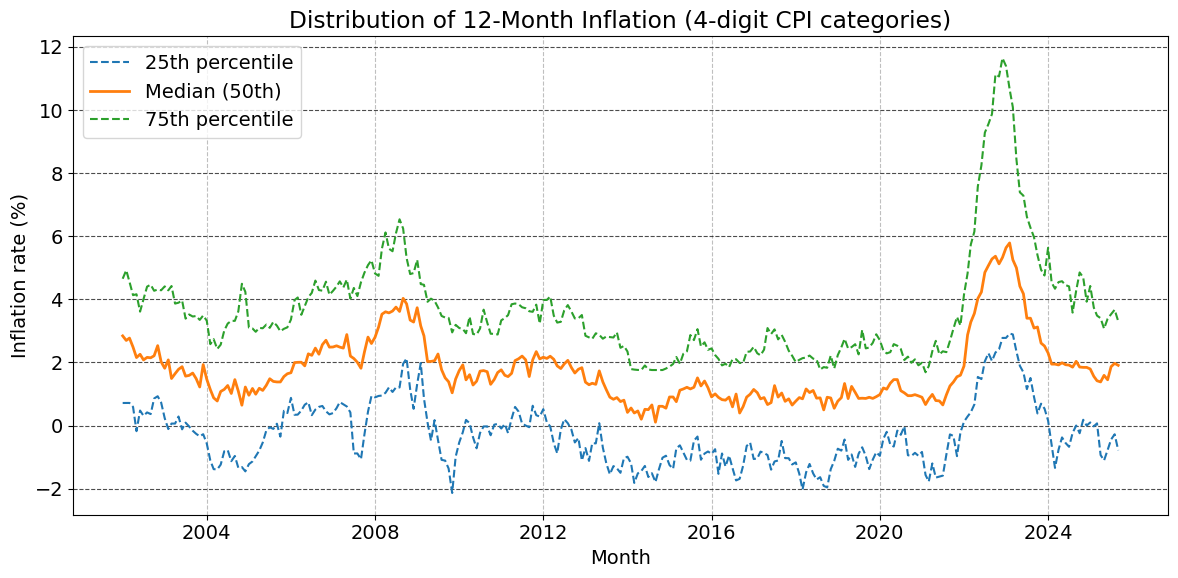

In [62]:
# Group by date and compute distribution percentiles
summary = (
    prices.groupby('date')['infl_12m']
          .agg(
              p25=lambda x: x.quantile(0.25),
              p50=lambda x: x.quantile(0.50),
              p75=lambda x: x.quantile(0.75)
          )
          .reset_index()
)


fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(summary['date'], summary['p25'], linestyle='--', label='25th percentile')
ax.plot(summary['date'], summary['p50'], linewidth=2, label='Median (50th)')
ax.plot(summary['date'], summary['p75'], linestyle='--', label='75th percentile')

ax.set_title('Distribution of 12-Month Inflation (4-digit CPI categories)')
ax.set_xlabel('Month')
ax.set_ylabel('Inflation rate (%)')
ax.legend()
ax.grid(True, axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

***1.4.3 - Plot histogram***

In [63]:
# Ensure we only use the relevant window
start, end = "2020-08-01", "2025-08-01"

# Get price levels for those months
df_2020 = prices.loc[prices['date'] == start, ['code3', 'INDHOLD']].rename(columns={'INDHOLD': 'p_2020'})
df_2025 = prices.loc[prices['date'] == end,   ['code3', 'INDHOLD']].rename(columns={'INDHOLD': 'p_2025'})

# Merge and compute percent change
change = (
    df_2020.merge(df_2025, on='code3', how='inner')
           .assign(pct_change=lambda d: (d['p_2025'] / d['p_2020'] - 1) * 100)
           .dropna(subset=['pct_change'])
)


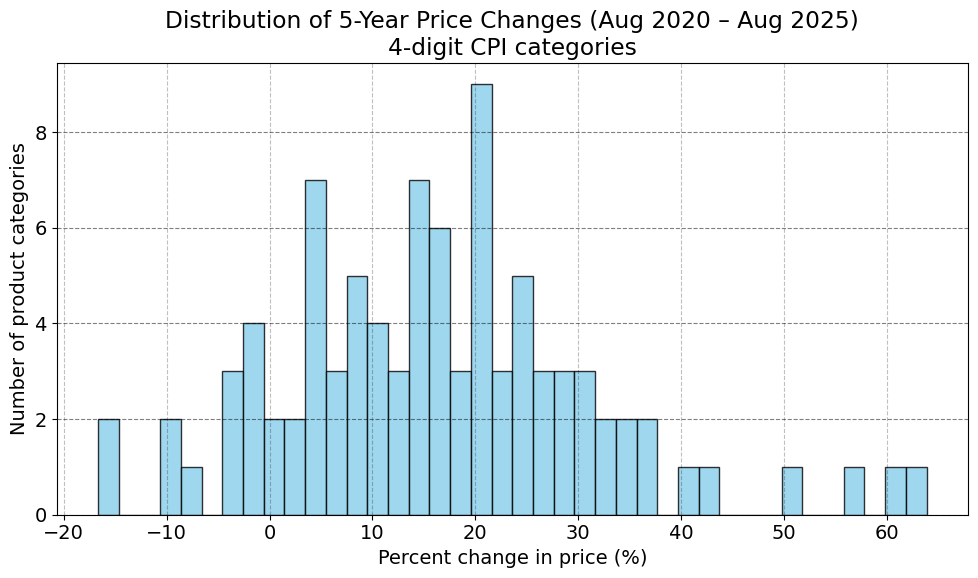

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(change['pct_change'], bins=40, color='skyblue', edgecolor='black', alpha=0.8)

ax.set_title('Distribution of 5-Year Price Changes (Aug 2020 – Aug 2025)\n4-digit CPI categories')
ax.set_xlabel('Percent change in price (%)')
ax.set_ylabel('Number of product categories')
ax.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

In [65]:
# Get the last available month 
latest_month = prices['date'].max()

print(prices.columns.tolist())

latest = prices.loc[prices['date'] == latest_month]

['VAREGR', 'ENHED', 'TID', 'INDHOLD', 'code3', 'name_raw', 'date', 'name', 'infl_12m']


In [66]:
# Sort by inflation rate
top10 = latest.nlargest(10, 'infl_12m')
bottom10 = latest.nsmallest(10, 'infl_12m')

print("Top 10 categories (highest inflation):")
print(top10[['code3', 'name', 'infl_12m']])

print("\nBottom 10 categories (lowest inflation):")
print(bottom10[['code3', 'name', 'infl_12m']])

Top 10 categories (highest inflation):
       code3                                name   infl_12m
3619  01.2.1               Coffee, tea and cocoa  25.869038
3613  01.1.4               Milk, cheese and eggs   8.199019
3611  01.1.2                                Meat   8.127490
3637  04.4.3                   Sewage collection   6.899110
3594  09.4.2                   Cultural services   6.470588
3614  01.1.5                       Oils and fats   6.376639
3608  12.5.4  Insurance connected with transport   5.945419
3641  04.5.3                        Liquid fuels   5.462185
3636  04.4.2                   Refuse collection   5.458681
3577  07.3.3          Passenger transport by air   5.392912

Bottom 10 categories (lowest inflation):
       code3                                               name   infl_12m
3640  04.5.2                                                Gas -21.414666
3639  04.5.1                                        Electricity -11.375661
3602  12.1.2              Electric

/var/folders/77/y_wqkb2d7nvcjj1l7m69s8cc0000gn/T/ipykernel_19628/1332446907.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


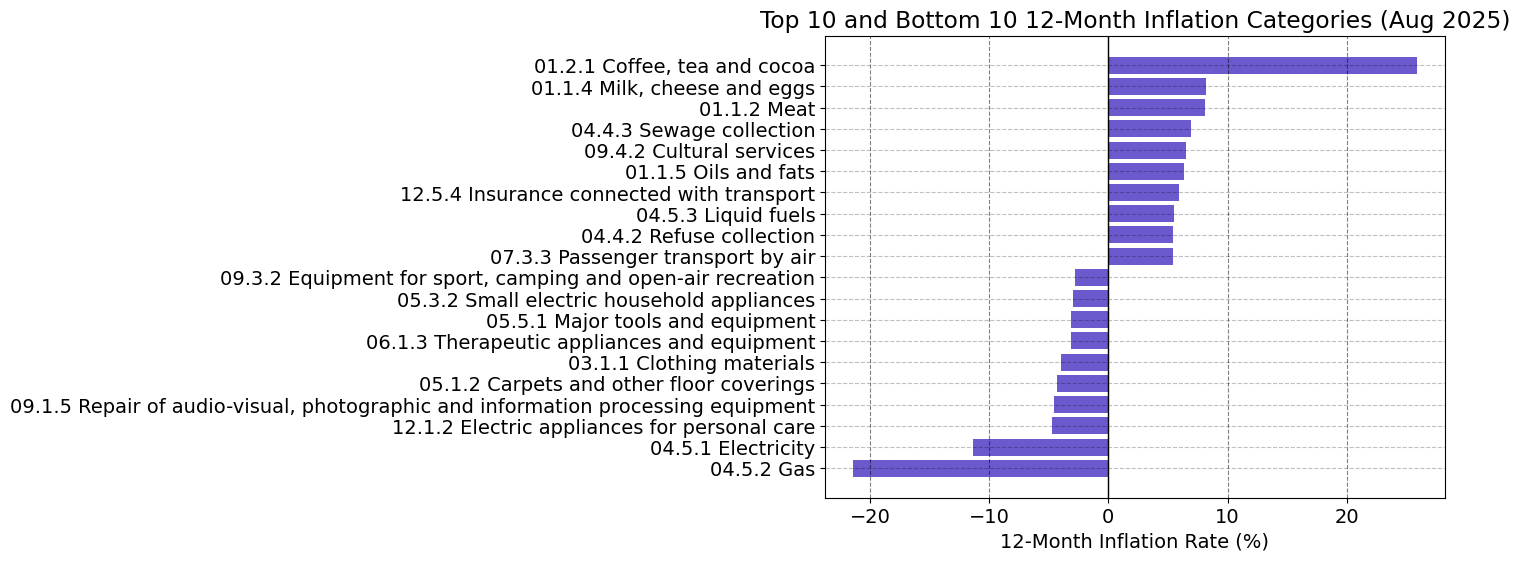

In [67]:
# Get the latest month (should be Aug 2025)
latest_month = prices['date'].max()

# Extract 12-month inflation rates for that month
latest = (
    prices.loc[prices['date'] == latest_month, ['code3', 'name', 'infl_12m']]
    .dropna(subset=['infl_12m'])
)

# Rank categories by inflation
top10 = latest.nlargest(10, 'infl_12m')
bottom10 = latest.nsmallest(10, 'infl_12m')

# Combine and label for plotting
ranked = pd.concat([top10, bottom10])
ranked['category'] = ranked['code3'] + ' ' + ranked['name']

# Sort for plotting (lowest at bottom, highest at top)
ranked_sorted = ranked.sort_values('infl_12m')

# Bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(ranked_sorted['category'], ranked_sorted['infl_12m'], color='slateblue')
ax.axvline(0, color='black', linewidth=1)
ax.set_title('Top 10 and Bottom 10 12-Month Inflation Categories (Aug 2025)')
ax.set_xlabel('12-Month Inflation Rate (%)')
ax.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

## 2. <a id='toc2_'></a>[International Comparison](#toc0_)

### 2.1. <a id='toc2_1_'></a>[CPI vs HICP](#toc0_)

In [68]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


Download CPI from Statistics Denmark
Number of rows downloaded: 549


,TYPE,TID,INDHOLD
0,Consumer price index,1980M01,33.0
1,Consumer price index,1980M05,34.5
2,Consumer price index,1980M09,35.5
3,Consumer price index,1981M01,36.5
4,Consumer price index,1981M05,38.6



After filtering (from 2010): 189 observations


,TYPE,TID,INDHOLD
90,Consumer price index,2010M01,91.6
91,Consumer price index,2010M05,93.4
92,Consumer price index,2010M09,93.9
93,Consumer price index,2011M01,94.1
94,Consumer price index,2011M05,96.3



CPI data after cleaning:


,time,CPI,date
90,2010M01,91.6,2010-01-01
228,2010M02,92.7,2010-02-01
366,2010M03,93.3,2010-03-01
502,2010M04,93.4,2010-04-01
91,2010M05,93.4,2010-05-01


CPI date range: 2010-01-01 00:00:00 → 2025-09-01 00:00:00

Download HICP from FRED
HICP date range: 1996-01-01 00:00:00 → 2025-09-01 00:00:00
Number of rows downloaded from FRED: 357


,date,HICP
0,1996-01-01,70.4
1,1996-02-01,70.8
2,1996-03-01,71.3
3,1996-04-01,71.5
4,1996-05-01,71.7



Merging CPI and HICP
Number of overlapping observations (since 2010): 189
Columns: ['time', 'CPI', 'date', 'HICP']
Date range: 2010-01 → 2025-09

Full merged dataset:


,time,CPI,date,HICP
0,2010M01,91.6,2010-01-01,92.5
1,2010M02,92.7,2010-02-01,93.4
2,2010M03,93.3,2010-03-01,94.0
3,2010M04,93.4,2010-04-01,94.2
4,2010M05,93.4,2010-05-01,94.2
...,...,...,...,...
184,2025M05,120.4,2025-05-01,120.5
185,2025M06,120.7,2025-06-01,120.9
186,2025M07,122.5,2025-07-01,122.9
187,2025M08,121.7,2025-08-01,122.0



Normalizing both series to average = 100 in 2019
Average values in 2019:


,CPI,HICP
0,103.0,102.533333



Merged data 2019=100:


,time,CPI,date,HICP,CPI_norm,HICP_norm
0,2010M01,91.6,2010-01-01,92.5,88.932039,90.214564
1,2010M02,92.7,2010-02-01,93.4,90.000000,91.092328
2,2010M03,93.3,2010-03-01,94.0,90.582524,91.677503
3,2010M04,93.4,2010-04-01,94.2,90.679612,91.872562
4,2010M05,93.4,2010-05-01,94.2,90.679612,91.872562



Plot CPI vs HICP


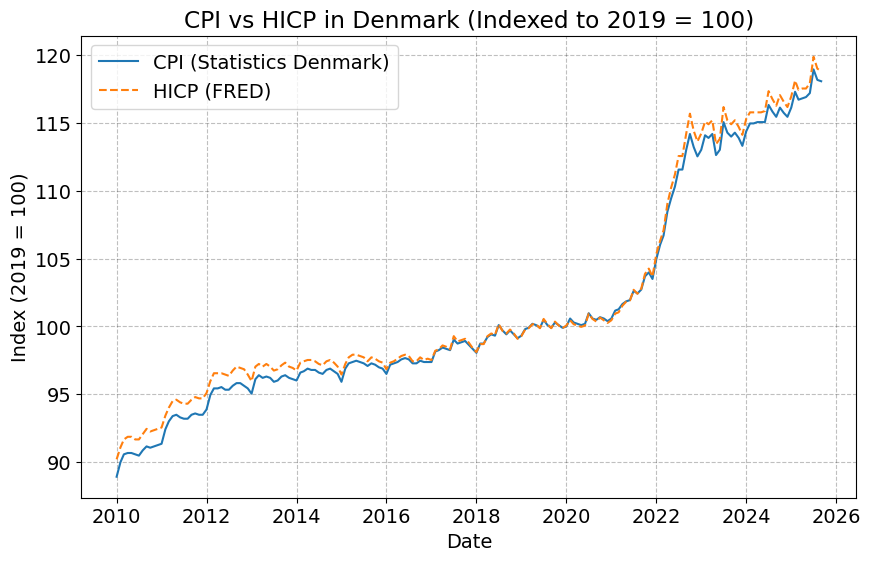

In [69]:
# Download CPI data from Statistics Denmark
print("Download CPI from Statistics Denmark")
api = DstApi('PRIS113')
params = api._define_base_params(language='en')
data = api.get_data(params)

# print first five rows to track data
print(f"Number of rows downloaded: {len(data)}")
display(data.head())

# keep only 2010 and onward
data = data[data['TID'] >= '2010M01']
print(f"\nAfter filtering (from 2010): {len(data)} observations")
display(data.head())

# rename to english (standardized names)
rename_map = {
    'TID': 'time', 'time': 'time',
    'INDHOLD': 'value', 'value': 'value',
    'TYPE': 'type', 'type': 'type'
}
for k, v in rename_map.items():
    if k in data.columns:
        data = data.rename(columns={k: v})

# date format, sort and rename
df_cpi = data[['time', 'value']].copy()
df_cpi['date'] = pd.to_datetime(df_cpi['time'], format='%YM%m')
df_cpi = df_cpi.sort_values('date')
df_cpi = df_cpi.rename(columns={'value': 'CPI'})

#print to keep track
print("\nCPI data after cleaning:")
display(df_cpi.head())
print(f"CPI date range: {df_cpi['date'].min()} → {df_cpi['date'].max()}")

# get HICP data from FRED
print("\nDownload HICP from FRED")
from fredapi import Fred
fred = Fred(api_key="60c118ce211cbc54a03242bbf7dc7c19")
hicp = fred.get_series('CP0000DKM086NEST').reset_index()
hicp.columns = ['date', 'HICP']

#keep track
print(f"HICP date range: {hicp['date'].min()} → {hicp['date'].max()}")
print(f"Number of rows downloaded from FRED: {len(hicp)}")
display(hicp.head())

# merging DST and FRED, and print
print("\nMerging CPI and HICP")
merged = pd.merge(df_cpi, hicp, on='date', how='inner')
merged = merged[merged['date'] >= '2010-01-01']
print(f"Number of overlapping observations (since 2010): {len(merged)}")
print(f"Columns: {list(merged.columns)}")
print(f"Date range: {merged['date'].min().strftime('%Y-%m')} → {merged['date'].max().strftime('%Y-%m')}")
print("\nFull merged dataset:")
display(merged)

# normalize such that index (2019=100), for asignmnet 2.2
print("\nNormalizing both series to average = 100 in 2019")

# keep sure that columns is num
merged['CPI'] = pd.to_numeric(merged['CPI'], errors='coerce')
merged['HICP'] = pd.to_numeric(merged['HICP'], errors='coerce')

# average CPI and HICP in 2019 
base_period = merged.loc[merged['date'].dt.year == 2019, ['CPI', 'HICP']].mean()
print("Average values in 2019:")
display(base_period.to_frame().T)

# normalized series
merged['CPI_norm'] = merged['CPI'] / base_period['CPI'] * 100
merged['HICP_norm'] = merged['HICP'] / base_period['HICP'] * 100

print("\nMerged data 2019=100:")
display(merged.head())

# Plot CPI vs HICP
print("\nPlot CPI vs HICP")
plt.figure(figsize=(10,6))
plt.plot(merged['date'], merged['CPI_norm'], label='CPI (Statistics Denmark)')
plt.plot(merged['date'], merged['HICP_norm'], label='HICP (FRED)', linestyle='--')
plt.title('CPI vs HICP in Denmark (Indexed to 2019 = 100)')
plt.ylabel('Index (2019 = 100)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


When comparing the CPI and the HICP, it can be noted that they are closely related. They both measure inflation, and can in fact be compared directly, although they are not perfectly identical. According to Statistics Denmark, they both use about the same data sources and methods. The main difference between them is how they include owner-occupied dwellings and private hospitals. CPI includes them, while HICP excludes them such that the data is comparable between countries. As seen in the figure above, the two have the same trend and level. There are minor differences because of the difference in what they cover.
It's indexed to 2019 because of it's use section 2.2

### 2.2. <a id='toc2_2_'></a>[Across countries](#toc0_)